# Using Convolutional Neural Networks

In [13]:
import os, json, cv2, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from keras import backend as K
K.set_image_dim_ordering('th')
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation

from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

from __future__ import division, print_function
from glob import glob
np.set_printoptions(precision=4, linewidth=100)



In [14]:
TRAIN_PATH = "data/train/"
TEST_PATH = "data/test/"
ROWS = 64
COLS = 64
CHANNELS = 3

In [15]:
# Train Images
train_images = [TRAIN_PATH + i for i in os.listdir(TRAIN_PATH)]
train_dog_images = [TRAIN_PATH + i for i in os.listdir(TRAIN_PATH) if 'dog' in i]
train_cat_images = [TRAIN_PATH + i for i in os.listdir(TRAIN_PATH) if 'cat' in i]

In [16]:
len(train_dog_images), len(train_cat_images)

(12500, 12500)

In [17]:
# Test Images
test_images = [TEST_PATH + i for i in os.listdir(TEST_PATH)]
len(test_images)

12500

In [18]:
def read_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

In [19]:
# Slicing of data
## Train data
train_images = train_dog_images[:1000] + train_cat_images[:1000]
random.shuffle(train_images)

## Test data
test_images = test_images[:25]

In [20]:
train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 2000
Processed 250 of 2000
Processed 500 of 2000
Processed 750 of 2000
Processed 1000 of 2000
Processed 1250 of 2000
Processed 1500 of 2000
Processed 1750 of 2000
Processed 0 of 25
Train shape: (2000, 3, 64, 64)
Test shape: (25, 3, 64, 64)


Generating the labels for data

In [21]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

Plot number of cats and dogs

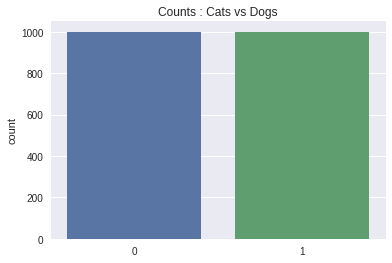

In [22]:
sns.countplot(labels)
sns.plt.title('Counts : Cats vs Dogs')

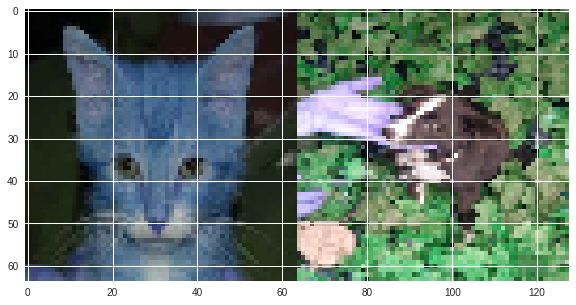

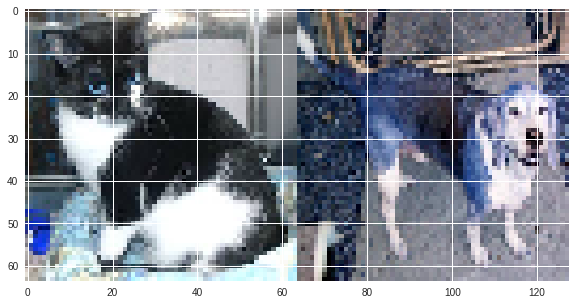

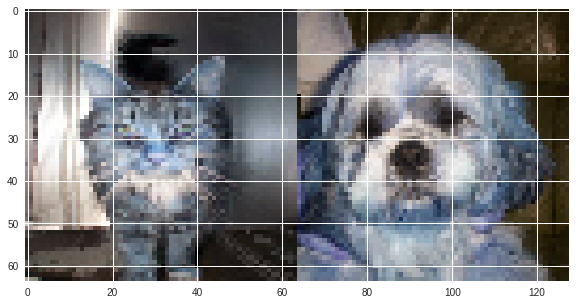

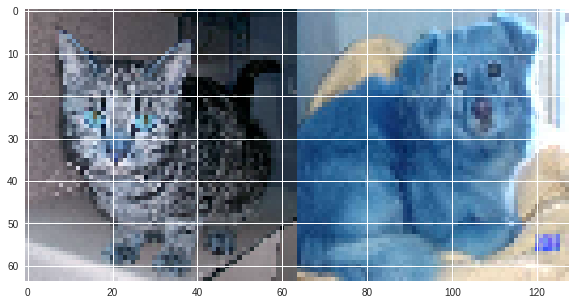

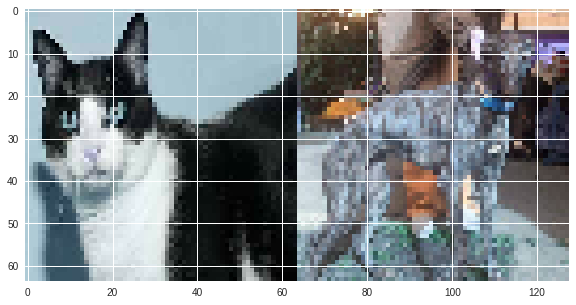

In [23]:
def show_animal(idx):
    cat = read_image(train_cat_images[idx])
    dog = read_image(train_dog_images[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,5):
    show_animal(idx)

In [26]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catVsDog():
    
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, 
                            border_mode='same', 
                            input_shape=(3, ROWS, COLS), 
                            activation='relu'))
    model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    #model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    #model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    #model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catVsDog()


In [27]:
nb_epoch = 10
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


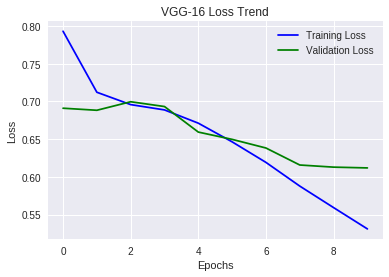

In [28]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

For fun, let's try bokeh plot for above matplotlib plot'

In [38]:
from bokeh.plotting import figure, output_file, show

# output to static HTML file
output_file("vgg16loss.html")

# create a new plot
p = figure(
   tools="pan,box_zoom,reset,save",
   y_axis_type="linear", y_range=[0.55, 0.80], title="VGG16 Loss Trend",
   x_axis_label='Epochs', y_axis_label='Loss'
)

# add some renderers
p.line(range(0,nb_epoch)[0::2], loss, line_color="red", line_width=3)
p.line(range(0,nb_epoch)[0::2], val_loss, line_color="green", line_width=3)

# show the results
show(p)

INFO:bokeh.core.state:Session output file 'vgg16loss.html' already exists, will be overwritten.
/usr/local/lib/python2.7/dist-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/usr/local/lib/python2.7/dist-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
